In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import datetime

data_path = r"E:\data_share_ths\dataset\UCF-101\images\selected_images\ucf101_jpegs_256"

In [2]:

image_labels  = {}
images_folder_counts = {}


for folder_name in os.listdir(data_path):
    class_name = folder_name.split("_")[1].lower()
    image_paths = []
    
    for filename in os.listdir(data_path+"\\"+folder_name):
        image_paths.append(data_path+"\\"+folder_name+"\\"+filename)
    images_folder_counts[folder_name] = image_paths
    image_labels[class_name] = image_paths

print(image_labels.keys())
print(len(image_labels['applyeyemakeup']))
print(len(image_labels['applylipstick']))
print(len(image_labels['archery']))



dict_keys(['applyeyemakeup', 'applylipstick', 'archery'])
144
201
133


In [3]:
img_interval = 5

In [4]:
### Add label for black image 
real_label = []
real_images =[]
for className,image_paths in images_folder_counts.items():
    temp_img_path = image_paths
    while len(temp_img_path)%img_interval != 0:
        temp_img_path.append("-")
    images_folder_counts[className] = temp_img_path

for key,file_len in images_folder_counts.items():
    print(key,len(file_len))
    

v_ApplyEyeMakeup_g03_c01 210
v_ApplyEyeMakeup_g03_c02 135
v_ApplyEyeMakeup_g03_c03 115
v_ApplyEyeMakeup_g03_c04 110
v_ApplyEyeMakeup_g03_c05 150
v_ApplyEyeMakeup_g03_c06 155
v_ApplyEyeMakeup_g04_c01 130
v_ApplyEyeMakeup_g04_c02 135
v_ApplyEyeMakeup_g04_c03 115
v_ApplyEyeMakeup_g04_c04 180
v_ApplyEyeMakeup_g04_c05 105
v_ApplyEyeMakeup_g04_c06 250
v_ApplyEyeMakeup_g04_c07 160
v_ApplyEyeMakeup_g05_c01 270
v_ApplyEyeMakeup_g05_c02 265
v_ApplyEyeMakeup_g05_c03 160
v_ApplyEyeMakeup_g05_c04 190
v_ApplyEyeMakeup_g05_c05 230
v_ApplyEyeMakeup_g05_c06 115
v_ApplyEyeMakeup_g05_c07 235
v_ApplyEyeMakeup_g06_c01 140
v_ApplyEyeMakeup_g06_c02 140
v_ApplyEyeMakeup_g06_c03 245
v_ApplyEyeMakeup_g06_c04 100
v_ApplyEyeMakeup_g06_c05 280
v_ApplyEyeMakeup_g06_c06 150
v_ApplyEyeMakeup_g06_c07 170
v_ApplyEyeMakeup_g07_c01 160
v_ApplyEyeMakeup_g07_c02 170
v_ApplyEyeMakeup_g07_c03 135
v_ApplyEyeMakeup_g07_c04 145
v_ApplyEyeMakeup_g07_c05 100
v_ApplyEyeMakeup_g07_c06 165
v_ApplyEyeMakeup_g07_c07 115
v_ApplyEyeMake

In [5]:
img_interval

5

In [6]:
## Create motin pair
X_total,Y_total =[],[]

for folder_name,file_paths in images_folder_counts.items():
    class_name = folder_name.split("_")[1].lower()
    temp_paths = []
    for i in range(1,len(file_paths),1):

        if (i)%img_interval !=0:
            temp_paths.append(file_paths[i-1])
        else:
            temp_paths.append(file_paths[i-1])
            Y_total.append([class_name])
            X_total.append(temp_paths)
            temp_paths = []
        

print("X_total :", len(X_total))
print(X_total[1])
print()
print("Y_total :", len(Y_total))
print(Y_total[1])


X_total : 12904
['E:\\data_share_ths\\dataset\\UCF-101\\images\\selected_images\\ucf101_jpegs_256\\v_ApplyEyeMakeup_g03_c01\\frame000006.jpg', 'E:\\data_share_ths\\dataset\\UCF-101\\images\\selected_images\\ucf101_jpegs_256\\v_ApplyEyeMakeup_g03_c01\\frame000007.jpg', 'E:\\data_share_ths\\dataset\\UCF-101\\images\\selected_images\\ucf101_jpegs_256\\v_ApplyEyeMakeup_g03_c01\\frame000008.jpg', 'E:\\data_share_ths\\dataset\\UCF-101\\images\\selected_images\\ucf101_jpegs_256\\v_ApplyEyeMakeup_g03_c01\\frame000009.jpg', 'E:\\data_share_ths\\dataset\\UCF-101\\images\\selected_images\\ucf101_jpegs_256\\v_ApplyEyeMakeup_g03_c01\\frame000010.jpg']

Y_total : 12904
[['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeup'], ['applyeyemakeu

In [7]:
## Convert to one hot
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
transformed = ohe.fit_transform(Y_total)
Y_total = transformed.toarray()


In [8]:
test_amount = 10
limit = len(X_total) - int(len(X_total)/test_amount)

X_train,Y_train =X_total[:limit],Y_total[:limit]
X_test,Y_test =X_total[limit:],Y_total[limit:]

In [9]:
Y_total

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

### Custom data generator

In [10]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
CHANNEL = 3

BATCH_SIZE = 16
OUTPUT_CHANNELS = 3
EPOCHS = 50

In [11]:
import tensorflow as tf

In [12]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, X_col, Y_col,
                 batch_size,
                width,height,channel):
        self.X_col =X_col
        self.Y_col =Y_col
        self.batch_size = batch_size
        self.width = width
        self.height = height
        self.channel = channel
        self.n = len(self.X_col)

    def read_img(self,path):
        
        #print("OK na sa",path)
        img = cv2.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
        
        #convert to tf and normalize
        tf_img = tf.cast(img, tf.float32)
        tf_img = (tf_img/127.5)-1
        return tf_img
    
    def create_emptyImage(self):
        img= np.zeros((IMG_WIDTH,IMG_HEIGHT,CHANNEL),dtype=int)
        tf_img = tf.cast(img, tf.float32)
        tf_img = (tf_img/127.5)-1
        return tf_img

    def image_stack(self,image_list):
        width, height,_ = image_list[0].shape
        stacked_image = np.zeros((width ,height,len(image_list)*self.channel), np.uint8)
        
        start_index = 0
        for i,cur_img in enumerate(image_list):
            end_index = start_index + self.channel

            stacked_image[:,:,start_index:end_index]=cur_img
            start_index = end_index
        return stacked_image




    def __get_input(self, batch_list):
        batch_img_list = []
        #print("batch_list : ",len(batch_list))
        for cur_path in batch_list:

            cur_img = None 
            if cur_path =="-":
                cur_img = self.create_emptyImage()
            else:
                cur_img = self.read_img(cur_path)

            
            batch_img_list.append(cur_img)
        return self.image_stack(batch_img_list)
    

    
    def __get_output(self, label):
        return label
    
    def __get_data(self, x_batches, y_batches):
        # Generates data containing batch_size samples
        X_batchs = np.asarray([self.__get_input(x) for x in x_batches])

        y_batches = np.asarray(self.__get_output(y_batches))
        return X_batchs,y_batches
    
    def __getitem__(self, index):
        
        X_batches = self.X_col[index*self.batch_size : (index+1)*self.batch_size]
        Y_batches = self.Y_col[index*self.batch_size : (index+1)*self.batch_size]
        X,y= self.__get_data(X_batches,Y_batches)       
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size
        

In [13]:
X_train[0]

['E:\\data_share_ths\\dataset\\UCF-101\\images\\selected_images\\ucf101_jpegs_256\\v_ApplyEyeMakeup_g03_c01\\frame000001.jpg',
 'E:\\data_share_ths\\dataset\\UCF-101\\images\\selected_images\\ucf101_jpegs_256\\v_ApplyEyeMakeup_g03_c01\\frame000002.jpg',
 'E:\\data_share_ths\\dataset\\UCF-101\\images\\selected_images\\ucf101_jpegs_256\\v_ApplyEyeMakeup_g03_c01\\frame000003.jpg',
 'E:\\data_share_ths\\dataset\\UCF-101\\images\\selected_images\\ucf101_jpegs_256\\v_ApplyEyeMakeup_g03_c01\\frame000004.jpg',
 'E:\\data_share_ths\\dataset\\UCF-101\\images\\selected_images\\ucf101_jpegs_256\\v_ApplyEyeMakeup_g03_c01\\frame000005.jpg']

In [14]:
train_gen = CustomDataGen(X_col=X_train,Y_col=Y_train,batch_size=BATCH_SIZE,width=IMG_WIDTH,height=IMG_HEIGHT,channel=CHANNEL)
test_gen = CustomDataGen(X_col=X_test,Y_col=Y_test,batch_size=BATCH_SIZE,width=IMG_WIDTH,height=IMG_HEIGHT,channel=CHANNEL)

In [15]:
cur_img_list =[]
for img,label in test_gen:
    #print(label)
    print(label)
    print(len(img))
    cur_img_list = img
    break
print(cur_img_list.shape)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
16
(16, 256, 256, 15)


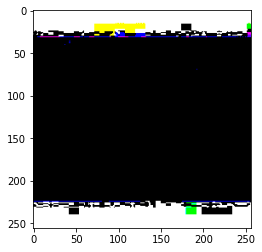

In [16]:
plt.imshow(cur_img_list[0][:,:,3:6])

### Create model

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPool2D,Dropout
from tensorflow.keras.applications.resnet50  import ResNet50

In [18]:
IMG_WIDTH = 256
IMG_HEIGHT = 256


input_shape = (IMG_WIDTH,IMG_HEIGHT,img_interval*CHANNEL)
input_shape

(256, 256, 15)

In [19]:
base_model = ResNet50(
    include_top=False,
    input_shape=input_shape,
    weights=None)
base_model.summary()

c:\Users\tharh\anaconda3\envs\tharhtet\lib\site-packages\keras\applications\resnet.py:135: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 15 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                5)]                                                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 15  0           ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  47104       ['conv1_pad[0][0]']              
                                )                                                          

In [20]:
model = Sequential([
                    base_model,
                    Flatten(),
					#Dropout(0.3),
                    Dense(units=100,activation='relu'),
                    Dense(units=100,activation='relu'),
					#Dropout(0.25),
                    Dense(units=OUTPUT_CHANNELS,activation='softmax')
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23625344  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 100)               13107300  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 36,743,047
Trainable params: 36,689,927
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [22]:

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [23]:
def lr_schedule(epoch,lr):
    # Learning Rate Schedule

    lr = lr
    total_epochs = num_epochs

    check_1 = int(total_epochs * 0.9)
    check_2 = int(total_epochs * 0.8)
    check_3 = int(total_epochs * 0.6)
    check_4 = int(total_epochs * 0.4)

    if epoch > check_1:
        lr *= 1e-4
    elif epoch > check_2:
        lr *= 1e-3
    elif epoch > check_3:
        lr *= 1e-2
    elif epoch > check_4:
        lr *= 1e-1

    print("[+] Current Lr rate : {} ".format(lr))
    return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [24]:
history = model.fit_generator(
      train_gen,
      validation_data=test_gen,
      steps_per_epoch=32,
      epochs=EPOCHS,
      callbacks=[tensorboard_callback],
      verbose=1)

C:\Users\tharh\AppData\Local\Temp\ipykernel_17224\2444345211.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/70


KeyboardInterrupt: 

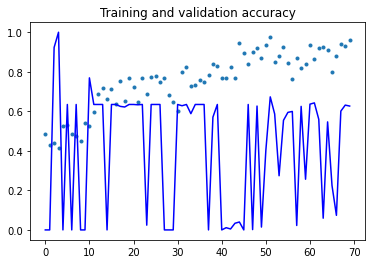

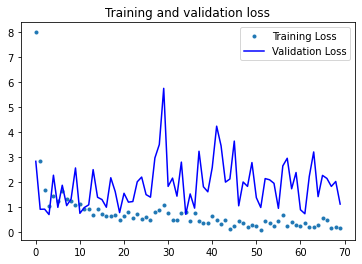

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '.', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, '.', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_name = "model/ep_{}_lr0001.h5".format(epochs)
model.save(model_name)

range(0, 70)

In [ ]:
## Sampel prediction
def image_stack(self,image_list):
    width, height,_ = image_list[0].shape
    stacked_image = np.zeros((width ,height,len(image_list)*self.channel), np.uint8)
    
    start_index = 0
    for i,cur_img in enumerate(image_list):
        end_index = start_index + self.channel

        stacked_image[:,:,start_index:end_index]=cur_img
        start_index = end_index
    return stacked_image

In [ ]:
test_data = None
for data,label in  test_gen:
    print(label)
    test_data = data
    break
test_data.shape

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


(8, 256, 256, 15)

(256, 256, 15)


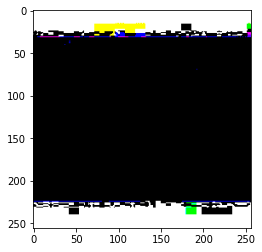

In [ ]:
idx = 0
test_input_data = test_data[idx]
print(test_input_data.shape)
plt.imshow(test_input_data[:,:,3:6])

In [ ]:
temp = np.array([test_input_data]) 

In [ ]:
result = model.predict(temp,batch_size=1)
print(result)

1/1 [==============================] - 1s 1s/step
[[0.8476002  0.15081178 0.00158797]]


In [ ]:
def prepare_frame(image):
    
    img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    
    #convert to tf and normalize
    tf_img = tf.cast(img, tf.float32)
    tf_img = (tf_img/127.5)-1


    return tf_img

## Sampel prediction
def image_stack(image_list):
    width, height,_ = image_list[0].shape
    stacked_image = np.zeros((IMG_WIDTH ,IMG_HEIGHT,len(image_list)*CHANNEL), np.uint8)
    
    start_index = 0
    for i,cur_img in enumerate(image_list):
        end_index = start_index + CHANNEL

        stacked_image[:,:,start_index:end_index]=cur_img
        start_index = end_index
    return stacked_image

In [ ]:
import tensorflow as tf
import numpy as np
import cv2 

video_path = r"E:\data_share_ths\dataset\UCF-101\UCF-101\ApplyEyeMakeup\v_ApplyEyeMakeup_g02_c04.avi"
video_path = r"E:\data_share_ths\dataset\UCF-101\UCF-101\ApplyLipstick\v_ApplyLipstick_g14_c01.avi"
#video_path = r"E:\data_share_ths\dataset\UCF-101\UCF-101\Archery\v_Archery_g08_c02.avi"

In [ ]:
classMap = ["ApplyEyeMakeup","ApplyLipstick","Archery"]

In [ ]:
cap = cv2.VideoCapture(video_path)
count = 0
buffer_frame= []

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    


    count = count+1

    tf_image = prepare_frame(frame)
    buffer_frame.append(tf_image)
    if len(buffer_frame)%img_interval ==0:
        
        stack_image = image_stack(buffer_frame)
        buffer_frame = []
        stack_image = np.array([stack_image]) 
        predicted_result = model.predict(stack_image,batch_size=1)

        index = (np.argmax(predicted_result))

        print(classMap[index])
    else:
        buffer_frame.append(tf_image)



    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
        break


print("Total Frame :",count)
cap.release()
cv2.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...
Total Frame : 176
